In [1]:
import os
os.chdir("..")

from src.data_loader import DatabaseConnection

In [2]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-08-22 07:12:21,310| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 54596 にバインドされました。


In [3]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [12]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/08/20 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240820.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [13]:
# 特徴量とターゲット

cols = df.columns.tolist()

targets_eval = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

targets_profit = ['ModelLife_category', 'GrossProfit_category']

features = [col for col in cols if col not in targets_eval + targets_profit + ['Name', 'ModelLife', 'GrossProfit', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


In [14]:
import pandas as pd

print('特徴量の数: ', len(features))

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

特徴量の数:  165


In [15]:
len(df)

482

In [16]:
print(len(df_train), len(df_test))
print(len(df_train)/ len(df))

389 93
0.8070539419087137


In [17]:
print(len(df_train[df_train['Kind']==0]), len(df_test[df_test['Kind']==0]))
print(len(df_train[df_train['Kind']==1]), len(df_test[df_test['Kind']==1]))

213 44
176 49


# 評価モデル構築

In [10]:
############### ハイパーパラメータのチューニング　###############
#import importlib
#import sys
#importlib.reload(sys.modules[model_tuning.__module__])

from src.hyperparameters_tuning import model_tuning


# 評価値に対して
# lightgbm
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_lightgbm.json')
mt_gbm.tune_models(features, targets_eval, df_train, model_kind='lightgbm_regressor', n_trials=1000)

最適化: minimize  rmse
--- Performance ---
trial: 146
rmse : 0.22338685305802322
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 15, 'learning_rate': 0.15052023160511316, 'n_estimators': 263, 'min_child_samples': 34, 'min_child_weight': 0.02934679931090091, 'subsample': 0.5330294175222869, 'colsample_bytree': 0.51298419307446, 'reg_alpha': 0.21202401074615504, 'reg_lambda': 1.185255152705955, 'max_bin': 108, 'lambda_l1': 1.7043836141522664, 'lambda_l2': 0.2220989236562508}
--- Spec ---
trial: 449
rmse : 0.19660877676655564
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 11, 'learning_rate': 0.02314934398305698, 'n_estimators': 243, 'min_child_samples': 46, 'min_child_weight': 0.0018676371040664119, 'subsample': 0.5259274643152787, 'colsample_bytree': 0.970260140106981, 'reg_alpha': 1.7611124665128508, 'reg_lambda': 0.08828308390114703, 'max_bin': 161, 'lambda_l1': 1.9097852060240934, 'lambda_l2': 0.35593689189490674}
--- Content ---
trial: 934
rmse : 

---- gbm tuned -----
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] 9


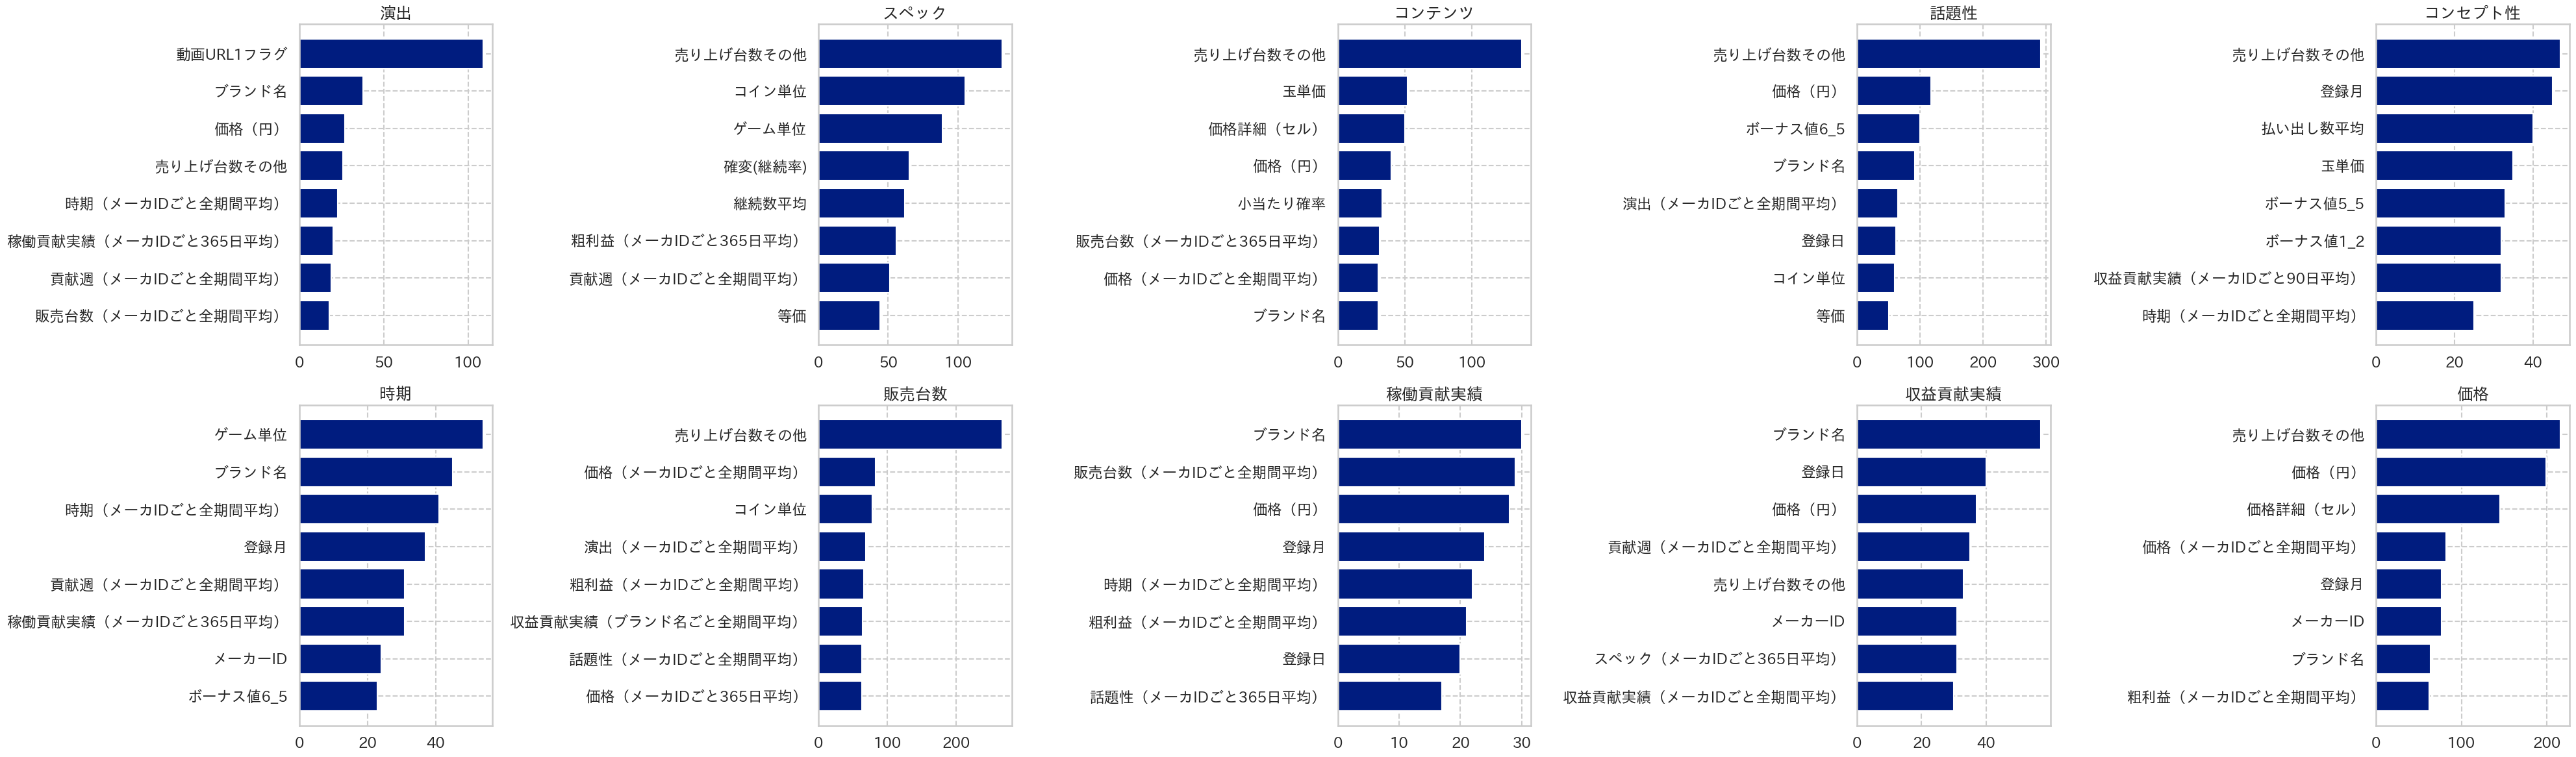

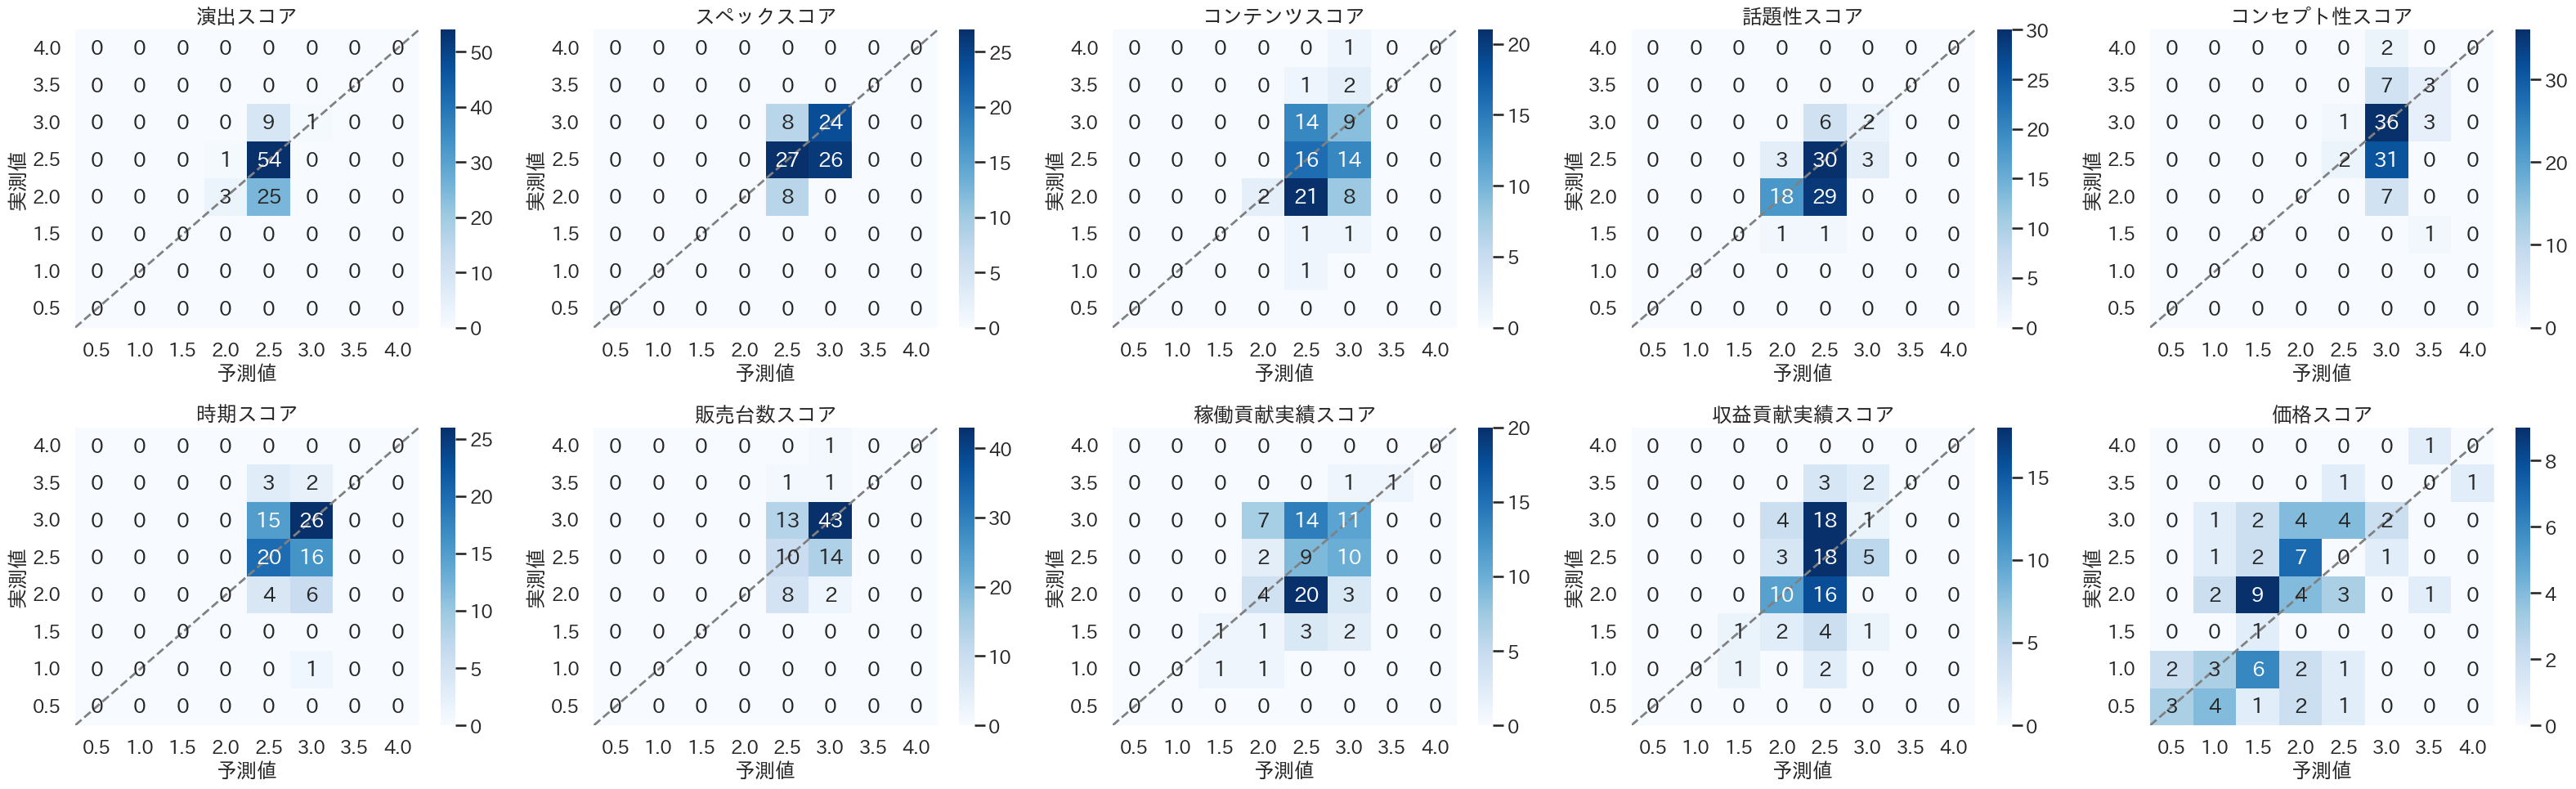

In [18]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240821'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets_eval)

# lightgbm
models_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_lightgbm.json',
                              model_kind='lightgbm_regressor')
df_output_gbm = m.predict_all(models_gbm, df_test)

print('---- gbm tuned -----')
suffix = 'gbm_tuned'
eval = evaluation(folder, suffix)
eval.generate(df_output_gbm, models_gbm, targets_eval, features)

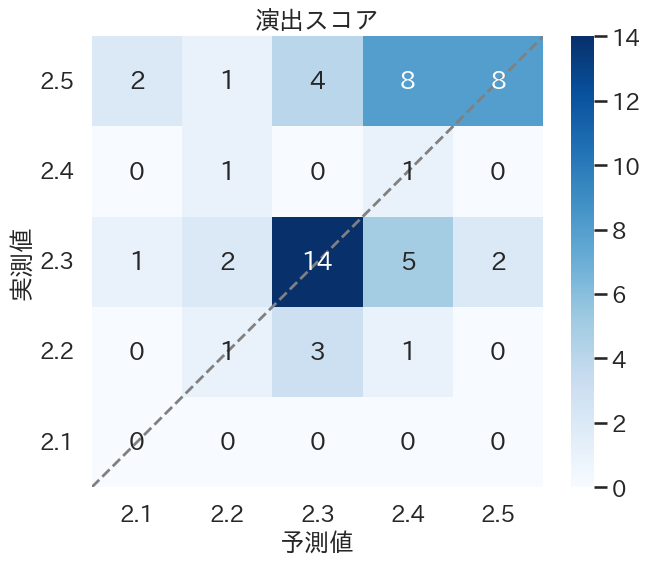

In [22]:
from data_columns.en_jp_dictionary import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

eval = evaluation(None, None)

title = 'Performance'

confusion_matrix = eval.create_confusion_matrix(df_output_gbm, 2, 2.5, 6, title)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title(f"{targets_jp[title]}スコア")

# 対角線に線を追加
labels = np.linspace(2, 2.5, 6)
n = len(labels)
ax.plot(range(n+1), n - 1 - np.array(range(n+1)), linestyle='--', color='gray')

ax.set_xticklabels([f"{label:.1f}" for label in labels[1:]], rotation=0)
ax.set_yticklabels(np.flip([f"{label:.1f}" for label in labels[1:]]))

ax.set_xlabel('予測値')
ax.set_ylabel('実測値')

plt.tight_layout()
plt.show()

# 貢献週と粗利益モデル

In [11]:
df = df[df['GrossProfit'] > 0]
df = df[df['ModelLife'] > 0]

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

print(len(df))
print(len(df_train), len(df_test))
print(len(df_train)/ len(df))
print('pachinko:', len(df_train[df_train['Kind']==0]), len(df_test[df_test['Kind']==0]))
print('slot:', len(df_train[df_train['Kind']==1]), len(df_test[df_test['Kind']==1]))

414
364 50
0.8792270531400966
pachinko: 198 23
slot: 166 27


In [13]:
############### ハイパーパラメータのチューニング　###############
import importlib
import sys
importlib.reload(sys.modules[model_tuning.__module__])

from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm.json')

mt_gbm.tune_models(features,
                   ['ModelLife_category', 'GrossProfit_category'],
                   df_train,
                   model_kind='lightgbm_classifier',
                   n_trials=1000,
                   loss='f1_weighted')

最適化: maximize  f1_weighted
--- ModelLife_category ---
trial: 630
f1_weighted : 0.2952062011923149
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 7, 'learning_rate': 0.216666446233466, 'n_estimators': 365, 'min_child_samples': 11, 'min_child_weight': 0.032572443521528154, 'subsample': 0.9500913655757596, 'colsample_bytree': 0.9702885867947997, 'reg_alpha': 1.7351263036660352, 'reg_lambda': 0.20984719981184952, 'max_bin': 203, 'lambda_l1': 1.90791989742838, 'lambda_l2': 1.1154299845470774}
--- GrossProfit_category ---
trial: 255
f1_weighted : 0.11634242738191167
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.16094842310995536, 'n_estimators': 360, 'min_child_samples': 48, 'min_child_weight': 0.02976385228422556, 'subsample': 0.9737848851760059, 'colsample_bytree': 0.5148188054195346, 'reg_alpha': 1.3135227625967747, 'reg_lambda': 0.6186542825545669, 'max_bin': 147, 'lambda_l1': 0.5824015127720514, 'lambda_l2': 0.00172703250060

---- gbm tuned -----
[0, 0] [5, 6] [6, 7]


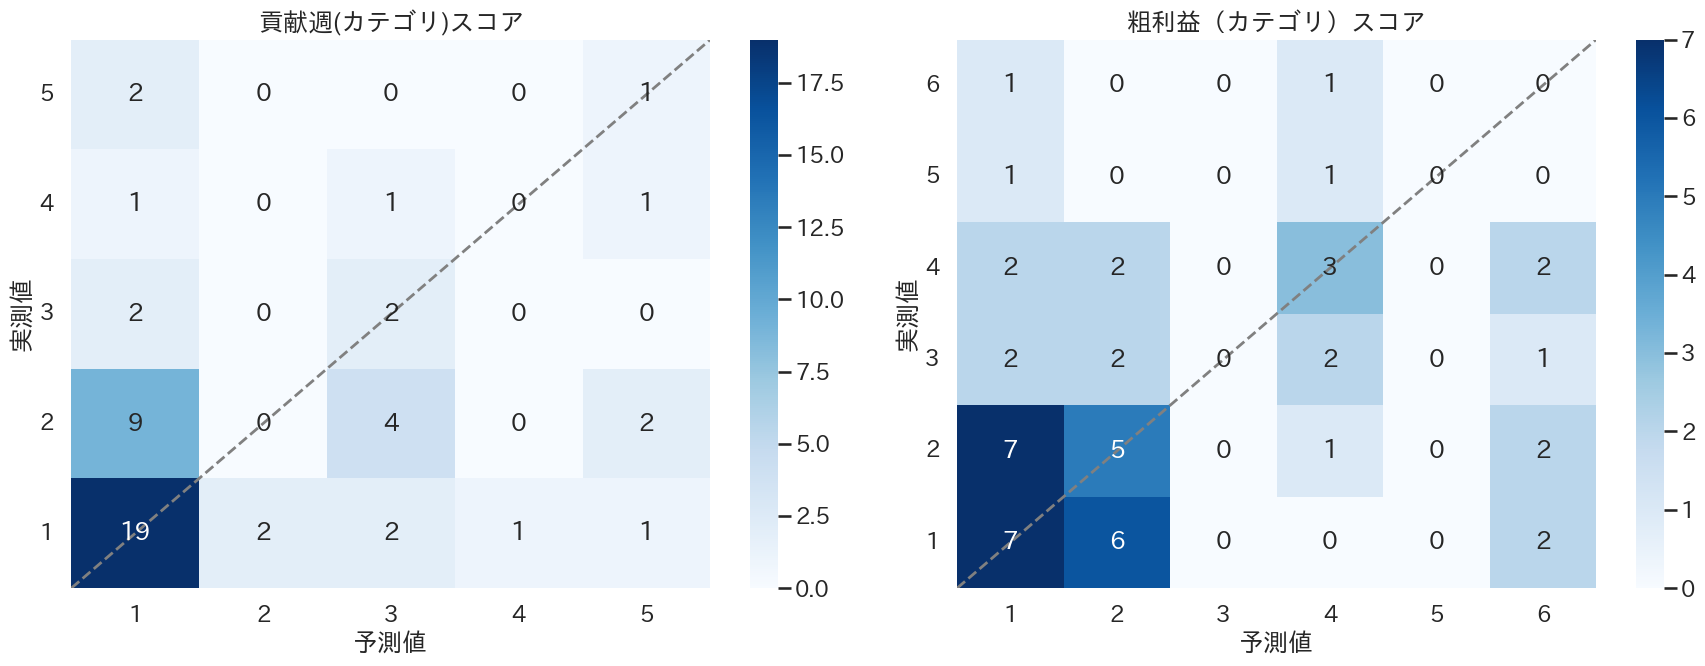

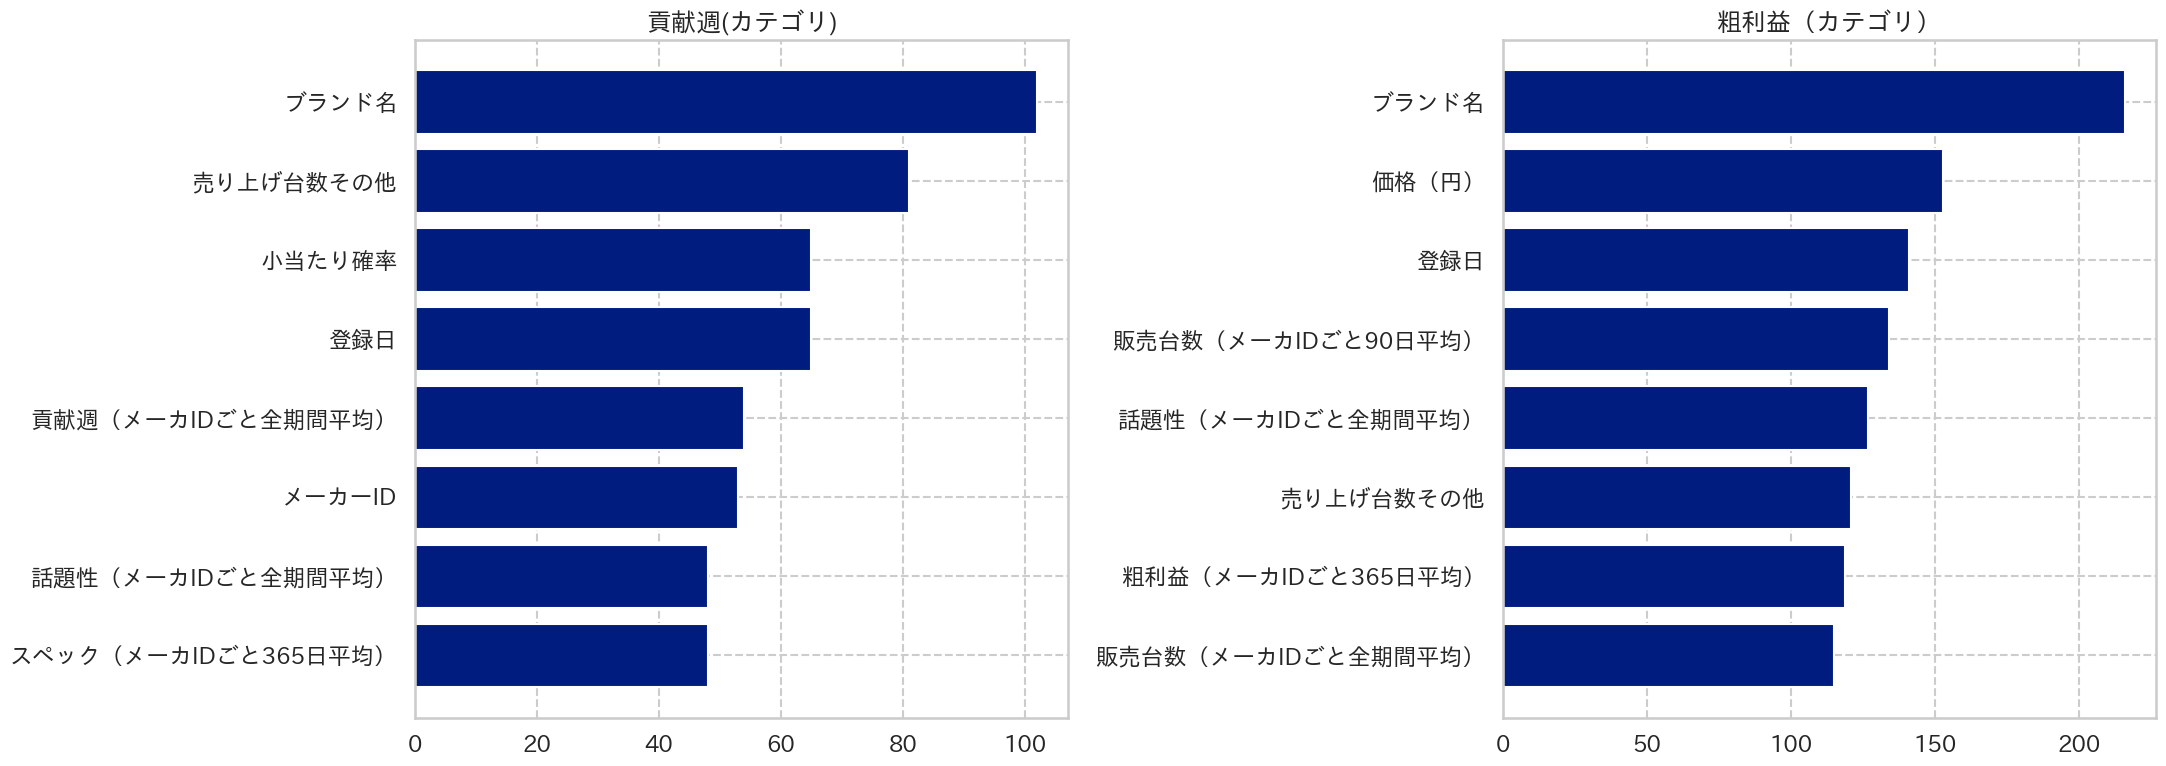

In [11]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240821'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife_category', 'GrossProfit_category'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm.json',
                              model_kind='lightgbm_classifier')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)

print('---- gbm tuned -----')
suffix = 'profit_gbm_tuned'
eval = evaluation(folder, suffix)
eval.generate(df_output_profit_gbm, models_profit_gbm, targets=['ModelLife_category', 'GrossProfit_category'], features=features, setting=1)